In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

!pip install pmdarima --quiet
import pmdarima as pm

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Loading Dataset

In [2]:
df = pd.read_csv('monthly-milk-production-pounds-p.csv', parse_dates = ['Month'], index_col = 'Month')
df.head()

,production
Month,
1962-01,589.0
1962-02,561.0
1962-03,640.0
1962-04,656.0
1962-05,727.0


In [4]:
df.tail()

,production
Month,
1975-10,827.0
1975-11,797.0
1975-12,843.0
NaN,NaN
Monthly milk production: pounds per cow. Jan 62 ? Dec 75,NaN


In [5]:
df.shape

(170, 1)

##### 168 monthly milk production records are present from Jan 1962 - Dec 1975

In [6]:
df.describe()

,production
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


In [7]:
df.isna().sum()

production    2
dtype: int64

##### No null values are present.

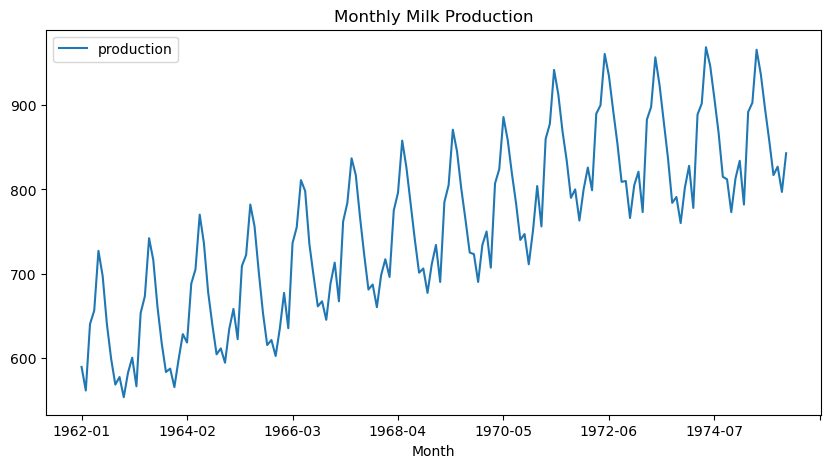

In [8]:
df.plot(figsize = (10,5))
plt.title('Monthly Milk Production')
plt.show()

##### We can observe that there is an increasing trend and very strong seasonality in our data.

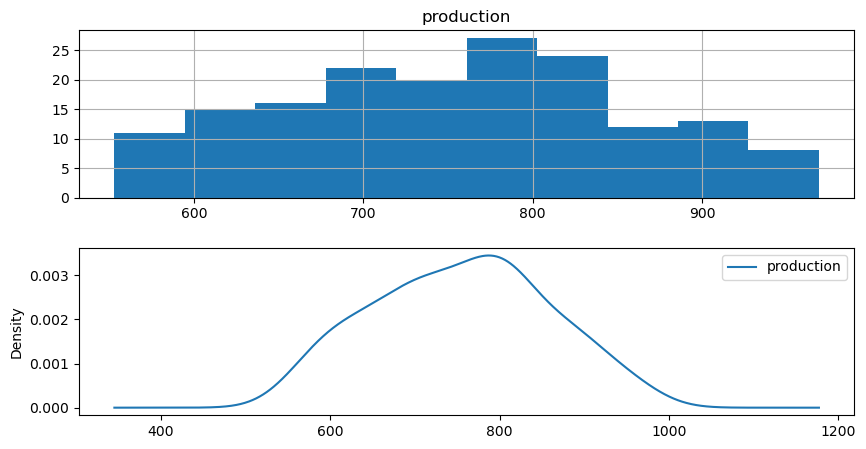

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (10,5))
df.hist(ax = ax1)
df.plot(kind = 'kde', ax = ax2)
plt.show()

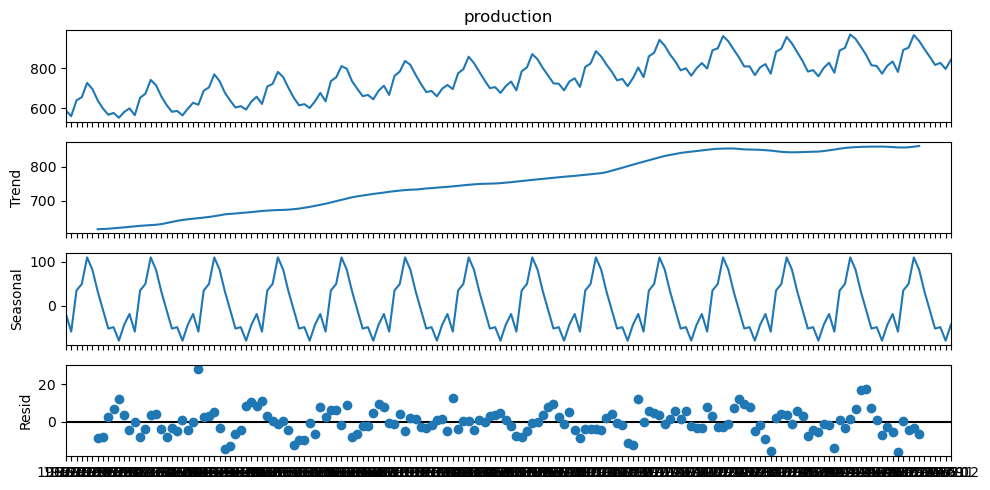

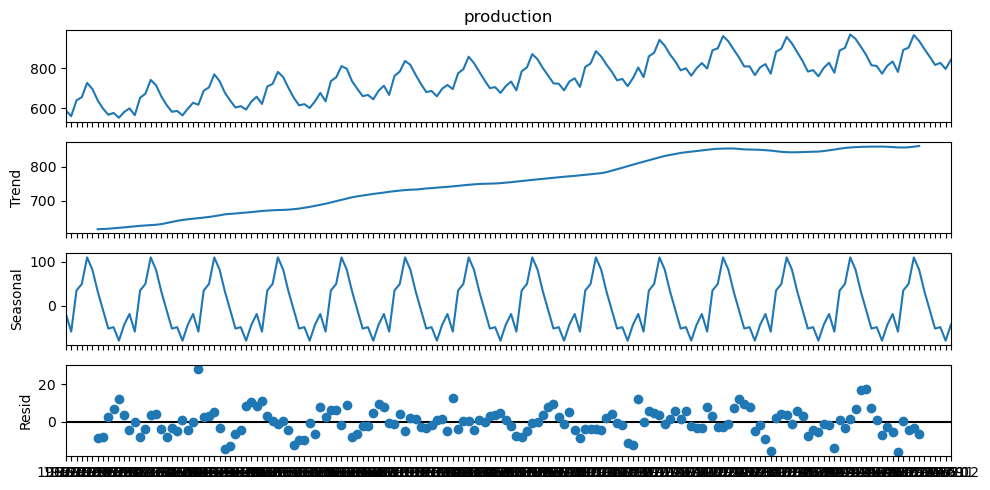

In [13]:
# Remove missing values
df_clean = df.dropna()

# or Impute missing values
# df_clean = df.fillna(method='ffill')  # Forward fill missing values
# df_clean = df.fillna(method='bfill')  # Backward fill missing values
# df_clean = df.fillna(df.mean())  # Fill missing values with mean
# df_clean = df.fillna(df.median())  # Fill missing values with median
# Or any other imputation method suitable for your data

# Perform seasonal decomposition on the cleaned data
decomposition = seasonal_decompose(df_clean['production'], period=12, model='additive')
plt.rcParams['figure.figsize'] = 10, 5
decomposition.plot()


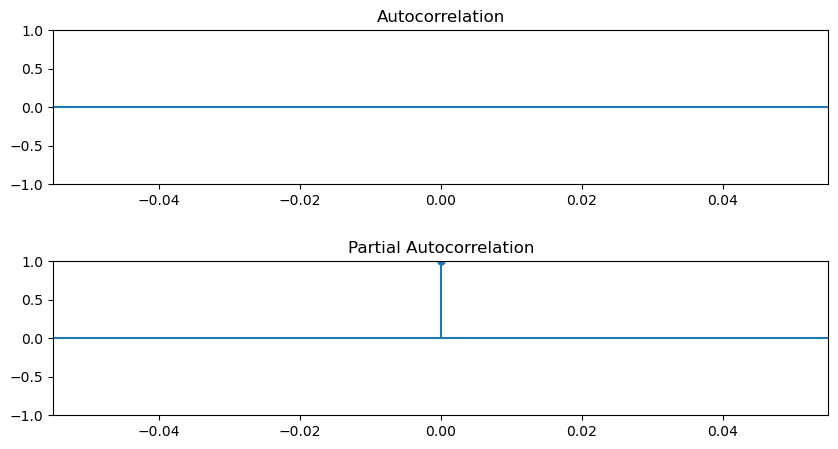

In [23]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(10, 5))

# Plot ACF
plot_acf(df['production'], lags=40, ax=ax1)

# Plot PACF
plot_pacf(df['production'], lags=40, ax=ax2)

plt.subplots_adjust(hspace=0.5)
plt.show()


## ADF Test

In [28]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(production):
    # Remove missing and infinite values
    production_clean = production.replace([np.inf, -np.inf], np.nan).dropna()
    result = adfuller(production_clean)
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', '#Observations Used']
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data has no unit root and is stationary.')
    else:
        print('Weak evidence against the null hypothesis, hence ACCEPT Ho. and the series is Not Stationary.')

adfuller_test(df['production'])


ADF Test Statistic : -1.3038115874221263
p-value : 0.6274267086030331
#Lags Used : 13
#Observations Used : 154
Weak evidence against the null hypothesis, hence ACCEPT Ho. and the series is Not Stationary.


In [29]:
df1 = df.diff().diff(12).dropna()

In [31]:
adfuller_test(df1['production'])

ADF Test Statistic : -5.038002274921972
p-value : 1.865423431878935e-05
#Lags Used : 11
#Observations Used : 143
Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data has no unit root and is stationary.


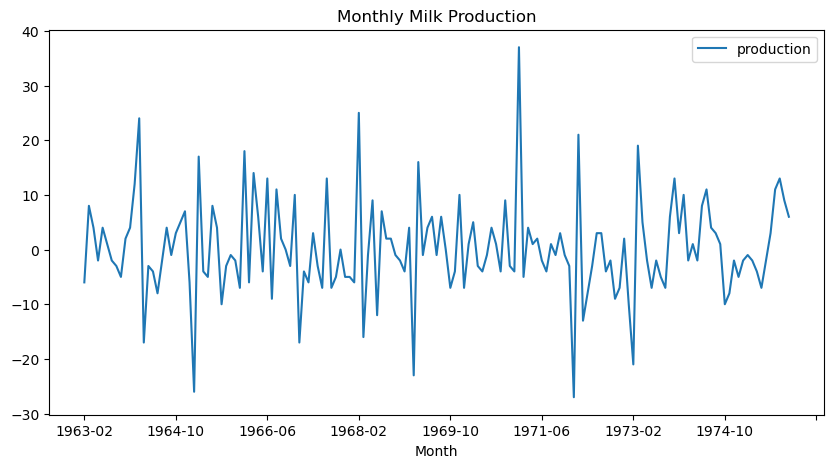

In [32]:
df1.plot(figsize=(10,5))
plt.title('Monthly Milk Production')
plt.show()

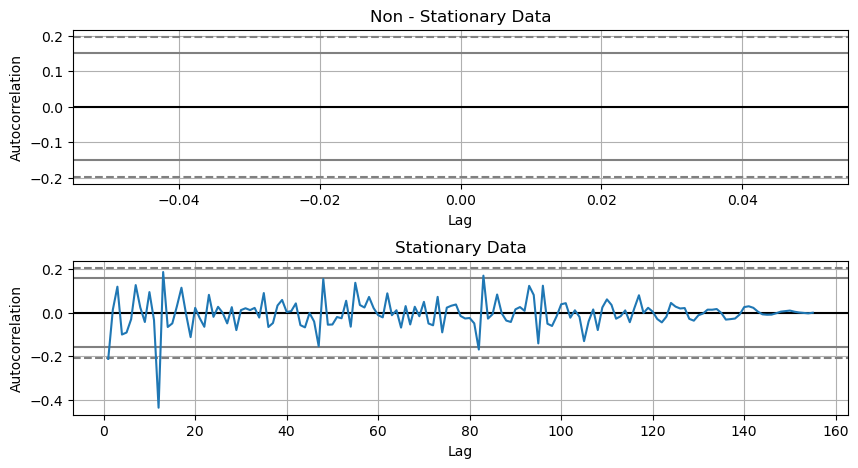

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (10,5))

ax1 = autocorrelation_plot(df['production'], ax = ax1)
ax1.set_title('Non - Stationary Data')

ax2 = autocorrelation_plot(df1['production'], ax = ax2)
ax2.set_title('Stationary Data')

plt.subplots_adjust(hspace = 0.5)
plt.show()

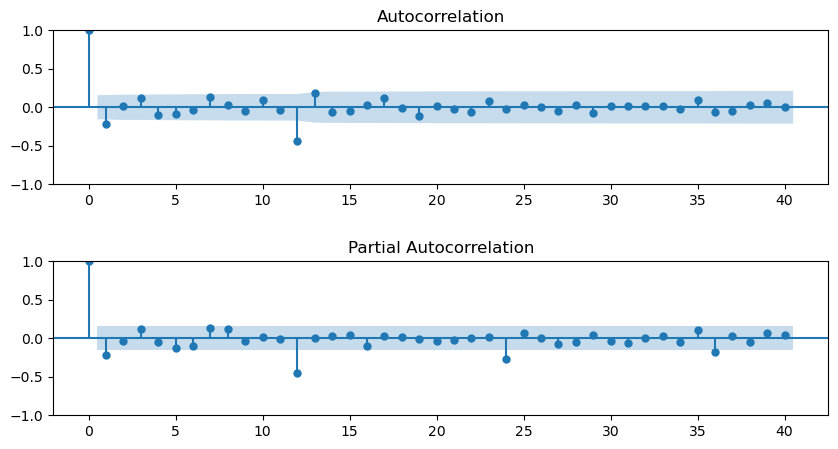

In [37]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (10,5))

ax1 = plot_acf(df1['production'], lags = 40, ax = ax1)
ax2 = plot_pacf(df1['production'], lags = 40, ax = ax2)

plt.subplots_adjust(hspace = 0.5)
plt.show()

## Model Parameter Estimation 

In [39]:
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

# Remove NaN values
df_clean = df.dropna()

# or Impute NaN values
# df_clean = df.fillna(method='ffill')  # Forward fill NaN values
# df_clean = df.fillna(method='bfill')  # Backward fill NaN values
# df_clean = df.fillna(df.mean())  # Fill NaN values with mean
# df_clean = df.fillna(df.median())  # Fill NaN values with median
# Or any other imputation method suitable for your data

# Fit ARIMA model
model = pm.auto_arima(df_clean['production'], d=1, D=1,
                      seasonal=True, m=12, 
                      start_p=0, start_q=0, max_order=6, test='adf', trace=True)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1074.131, Time=1.40 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1119.969, Time=0.29 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1081.584, Time=0.63 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1066.296, Time=1.47 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1114.995, Time=0.35 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1068.030, Time=1.68 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1067.976, Time=3.08 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1082.123, Time=0.60 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=8.75 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1072.280, Time=0.73 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1068.064, Time=1.61 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1067.796, Time=1.32 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1066.207, Time=1.07 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1114.845, Time=0.30 sec
 ARIMA(1,1,0)(1,1,1)[12]

In [40]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  168
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -530.104
Date:                              Mon, 06 May 2024   AIC                           1066.207
Time:                                      09:44:47   BIC                           1075.337
Sample:                                  01-01-1962   HQIC                          1069.916
                                       - 12-01-1975                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2253      0.077     -2.925      0.003      -0.376      -0.074
ma.S.L12      -0.6190      0.070     -8.825      0.000      -0.757      -0.482
sigma2        52.6908      4.897     10.759      0.000      43.093      62.289
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.11
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             0.74
Prob(H) (two-sided):                  0.49   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
train = df[:int(0.85*(len(df)))]
test = df[int(0.85*(len(df))):]

train.shape, test.shape

((144, 1), (26, 1))

In [43]:
model = SARIMAX(train['production'],
                order = (1,1,0), seasonal_order = (0,1,1,12))
results = model.fit(disp = False)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           production   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -452.127
Date:                              Mon, 06 May 2024   AIC                            910.254
Time:                                      09:45:29   BIC                            918.879
Sample:                                  01-01-1962   HQIC                           913.759
                                       - 12-01-1973                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2660      0.086     -3.085      0.002      -0.435      -0.097
ma.S.L12      -0.6329      0.082     -7.763      0.000      -0.793      -0.473
sigma2        55.5590      5.625      9.878      0.000      44.535      66.583
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                36.05
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.81
Prob(H) (two-sided):                  0.64   Kurtosis:                         4.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### We have created a SARIMAX model using the best parameters on our training data giving us an AIC Score of 897.205

## Model Validation

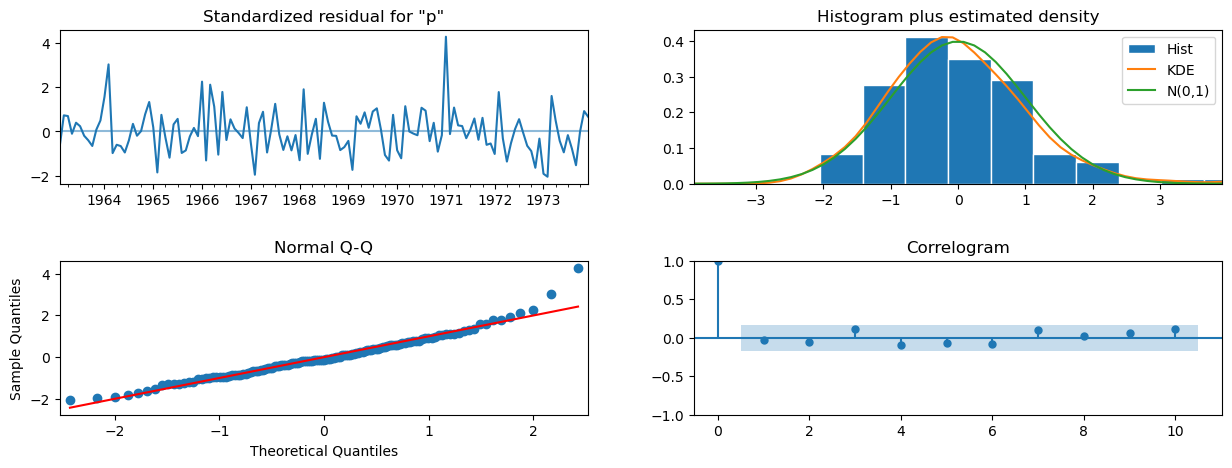

In [44]:
results.plot_diagnostics(figsize = (15, 5))
plt.subplots_adjust(hspace = 0.5)
plt.show()

In [45]:
start = len(train)
end = len(train) + len(test) - 1
predictions = results.predict(start = start, end = end, dynamic = False, typ = 'levels').rename('SARIMA(1,1,0)(0,1,1,12) Test predictions')

In [47]:
for i in range(len(predictions)):
    print(f"predicted = {predictions[i]:<11.10}, expected = {test['production'][i]}")

predicted = 826.239496 , expected = 828.0
predicted = 785.7133177, expected = 778.0
predicted = 886.1668611, expected = 889.0
predicted = 901.4161943, expected = 902.0
predicted = 962.3718985, expected = 969.0
predicted = 933.3161945, expected = 947.0
predicted = 890.0605185, expected = 908.0
predicted = 849.8086388, expected = 867.0
predicted = 803.0241968, expected = 815.0
predicted = 808.4106878, expected = 812.0
predicted = 773.5108544, expected = 773.0
predicted = 813.4363395, expected = 813.0
predicted = 838.2277214, expected = 834.0
predicted = 797.5547242, expected = 782.0
predicted = 898.047326 , expected = 892.0
predicted = 913.2862685, expected = 903.0
predicted = 974.2447369, expected = 966.0
predicted = 945.1882975, expected = 937.0
predicted = 901.9328172, expected = 896.0
predicted = 861.6808854, expected = 858.0
predicted = 814.8964573, expected = 817.0
predicted = 820.2829446, expected = 827.0
predicted = 785.3831122, expected = 797.0
predicted = 825.308597 , expected 

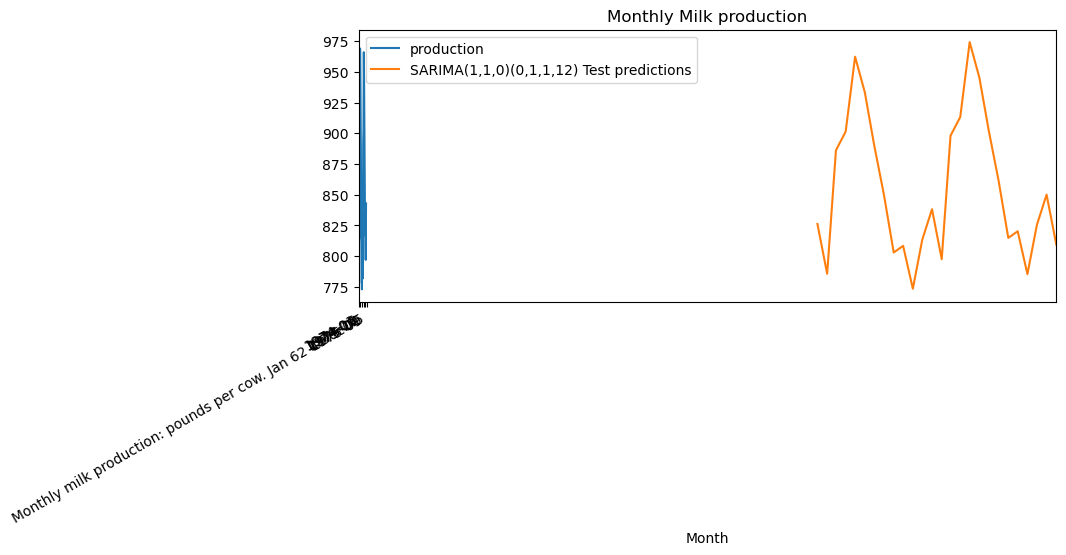

In [58]:
import matplotlib.pyplot as plt

# Assuming 'test' contains the observed production data and 'predictions' contains the predicted values

title = 'Monthly Milk production'
ax = test['production'].plot(legend=True, figsize=(9, 4), title=title)  # Plot observed production data
predictions.plot(legend=True, ax=ax)  # Plot predicted values on the same plot
ax.autoscale(axis='x', tight=True)  # Autoscale x-axis

plt.show()


In [60]:
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Assuming 'test' contains the observed production data and 'predictions' contains the predicted values

# Drop rows with NaN values from both test and predictions
test_clean = test.dropna()
predictions_clean = predictions.dropna()

# Ensure lengths match by truncating the longer series
min_length = min(len(test_clean['production']), len(predictions_clean))
test_clean = test_clean.iloc[:min_length]
predictions_clean = predictions_clean.iloc[:min_length]

# Calculate evaluation metrics
evaluation_results = pd.DataFrame({'r2_score': [r2_score(test_clean['production'], predictions_clean)]}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test_clean['production'], predictions_clean)
evaluation_results['mean_squared_error'] = mean_squared_error(test_clean['production'], predictions_clean)

print(evaluation_results)


   r2_score  mean_absolute_error  mean_squared_error
0  0.973517             7.714062           89.988164


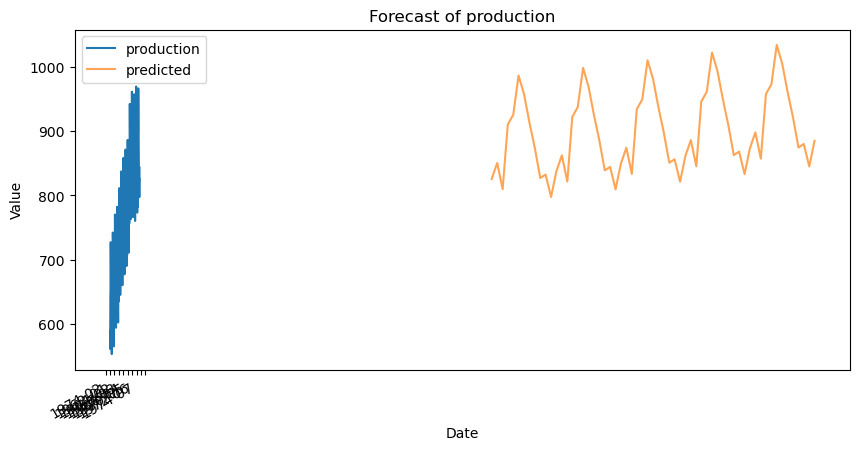

In [62]:
forecast = results.get_prediction(start = '1975-12-01', end = '1980-12-01')
idx = np.arange(len(forecast.predicted_mean))

forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

fig, ax = plt.subplots()
df.plot(ax = ax, label='observed')
forecast_values.plot(ax = ax, label = 'predicted', alpha = 0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()
ax.set_title('Forecast of production')
plt.show()

##### Here is the forecast for the next 4 years!